# 1. Setup / Imports & helper utilities

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Plot display settings
plt.rcParams['figure.figsize'] = (10,5)  # set default figure size (you can change in each plot)

# Paths (adjust if needed)
APPS_CSV = "apps.csv"               # or "/mnt/data/apps.csv"
REVIEWS_CSV = "user_reviews.csv"    # or "/mnt/data/user_reviews.csv"

# Quick file existence check:
for p in (APPS_CSV, REVIEWS_CSV):
    print(f"{p}: {'FOUND' if os.path.exists(p) else 'MISSING'}")


apps.csv: FOUND
user_reviews.csv: FOUND


# 2. Data Preparation (cleaning & correct data types)

In [4]:
apps = pd.read_csv(APPS_CSV)
reviews = pd.read_csv(REVIEWS_CSV)

# Quick peek
print("Apps shape:", apps.shape)
display(apps.head())

Apps shape: (9659, 14)


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
print("\nReviews shape:", reviews.shape)
display(reviews.head())


Reviews shape: (64295, 5)


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [6]:
# Common cleaning routines (adapt column names if your file differs)
# 1) Strip whitespace from column names
apps.columns = apps.columns.str.strip()
reviews.columns = reviews.columns.str.strip()

# 2) Normalize common columns: 'Rating', 'Size', 'Installs', 'Price', 'Last Updated'
# Example conversions:
def clean_rating(df, col='Rating'):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"{col} -> numeric, nulls: {df[col].isna().sum()}")

def clean_installs(df, col='Installs'):
    if col in df.columns:
        s = df[col].astype(str).str.replace('[+,]', '', regex=True).str.replace('Free', '', regex=False).str.strip()
        s = s.replace({'Varies with device': np.nan})
        df[col] = pd.to_numeric(s, errors='coerce')

def clean_price(df, col='Price'):
    if col in df.columns:
        s = df[col].astype(str).str.replace('[$,]', '', regex=True).str.strip()
        s = s.replace({'Everyone': np.nan})
        df[col] = pd.to_numeric(s, errors='coerce')

clean_rating(apps, 'Rating')
clean_installs(apps, 'Installs')
clean_price(apps, 'Price')

Rating -> numeric, nulls: 1463


In [7]:
# 3) Clean 'Size' (e.g., "19M", "1,000k", "Varies with device")
if 'Size' in apps.columns:
    def size_to_kb(s):
        s = str(s).strip()
        if s in ['Varies with device', '', 'nan', 'None']:
            return np.nan
        if s.endswith('M'):
            try: return float(s[:-1]) * 1024
            except: return np.nan
        if s.endswith('k'):
            try: return float(s[:-1])
            except: return np.nan
        # number alone in bytes? try numeric
        try:
            return float(s) / 1024
        except:
            return np.nan
    apps['Size_kb'] = apps['Size'].apply(size_to_kb)

# 4) Dates
if 'Last Updated' in apps.columns:
    apps['Last Updated'] = pd.to_datetime(apps['Last Updated'], errors='coerce')

# 5) Drop exact duplicates
before = len(apps)
apps = apps.drop_duplicates()
after = len(apps)
print(f"Dropped exact duplicates: {before-after}")

# Show cleaned dtypes summary
display(apps.info())

Dropped exact duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      9659 non-null   int64         
 1   App             9659 non-null   object        
 2   Category        9659 non-null   object        
 3   Rating          8196 non-null   float64       
 4   Reviews         9659 non-null   int64         
 5   Size            8432 non-null   float64       
 6   Installs        9659 non-null   int64         
 7   Type            9659 non-null   object        
 8   Price           9659 non-null   float64       
 9   Content Rating  9659 non-null   object        
 10  Genres          9659 non-null   object        
 11  Last Updated    9659 non-null   datetime64[ns]
 12  Current Ver     9651 non-null   object        
 13  Android Ver     9657 non-null   object        
 14  Size_kb         8432 non-nul

None

# 3. Category Exploration

In [13]:
category_col = 'Category'  # change to match dataset

if category_col not in apps.columns:
    raise KeyError(f"'{category_col}' column not found in apps dataset. Columns: {apps.columns.tolist()}")

cat_counts = apps[category_col].value_counts().rename_axis('category').reset_index(name='count')
display(cat_counts.head(15))

,category,count
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395
5,PERSONALIZATION,376
6,PRODUCTIVITY,374
7,LIFESTYLE,369
8,FINANCE,345
9,SPORTS,325


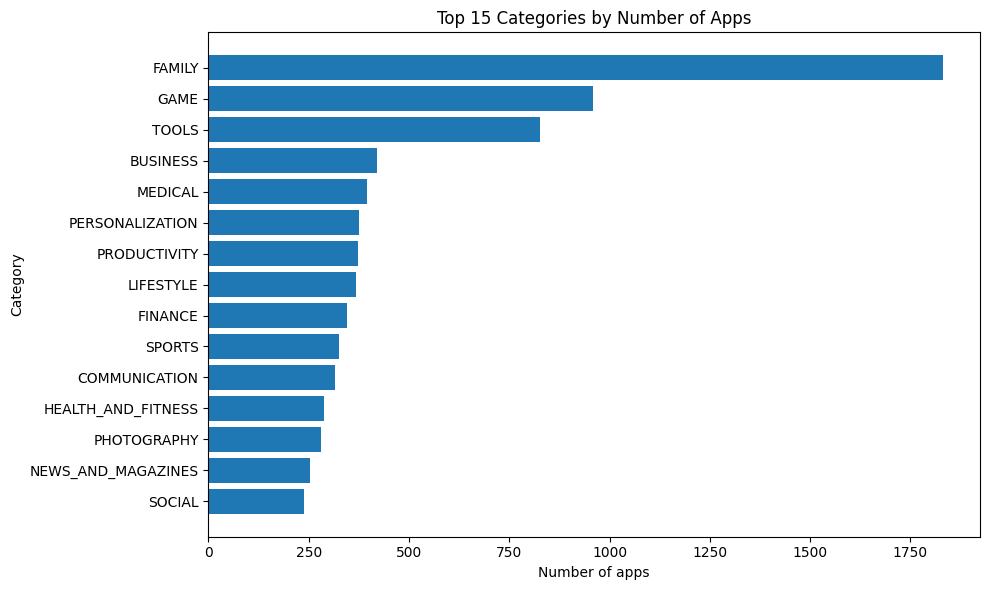

In [11]:
# Bar chart - top 15 categories
top_n = 15
top = cat_counts.head(top_n)
plt.figure(figsize=(10,6))
plt.barh(top['category'][::-1], top['count'][::-1])
plt.title(f"Top {top_n} Categories by Number of Apps")
plt.xlabel("Number of apps")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

In [12]:
# Percentage share
cat_counts['pct'] = 100 * cat_counts['count'] / cat_counts['count'].sum()
display(cat_counts.head(10))

,category,count,pct
0,FAMILY,1832,18.966767
1,GAME,959,9.928564
2,TOOLS,827,8.561963
3,BUSINESS,420,4.348276
4,MEDICAL,395,4.089450
5,PERSONALIZATION,376,3.892743
6,PRODUCTIVITY,374,3.872036
7,LIFESTYLE,369,3.820271
8,FINANCE,345,3.571798
9,SPORTS,325,3.364738


# 4. Metrics Analysis (ratings, size, installs, price)

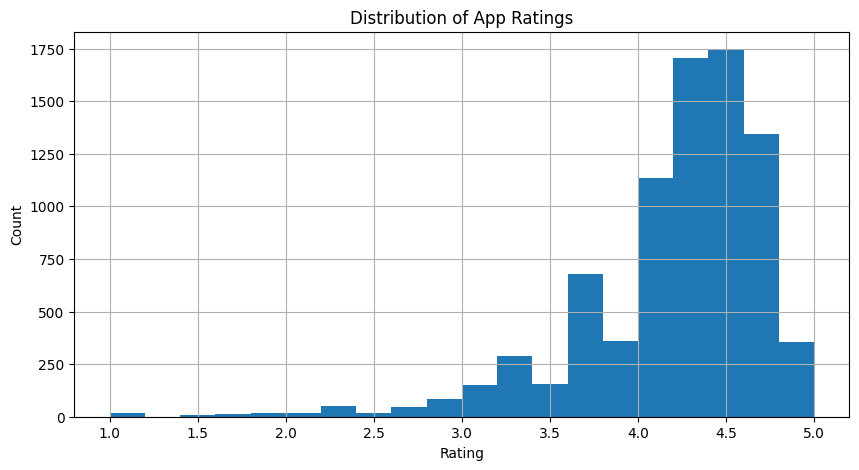

Rating stats:
 count    8196.000000
mean        4.173243
std         0.536625
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64


In [19]:
# Ratings distribution
if 'Rating' in apps.columns:
    plt.figure()
    apps['Rating'].dropna().hist(bins=20)
    plt.title("Distribution of App Ratings")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.show()
    print("Rating stats:\n", apps['Rating'].describe())

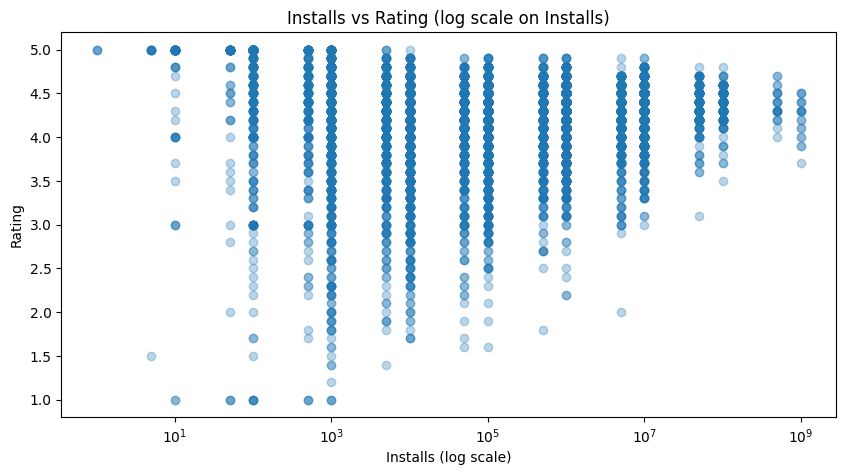

In [16]:
# Installs vs Rating (scatter)
if 'Installs' in apps.columns and 'Rating' in apps.columns:
    # remove extreme nulls
    df_scatter = apps.dropna(subset=['Installs', 'Rating'])
    plt.figure()
    plt.scatter(df_scatter['Installs'], df_scatter['Rating'], alpha=0.3)
    plt.xscale('log')  # installs are usually skewed
    plt.title("Installs vs Rating (log scale on Installs)")
    plt.xlabel("Installs (log scale)")
    plt.ylabel("Rating")
    plt.show()

Free vs Paid counts:


is_paid
False    8903
True      756
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

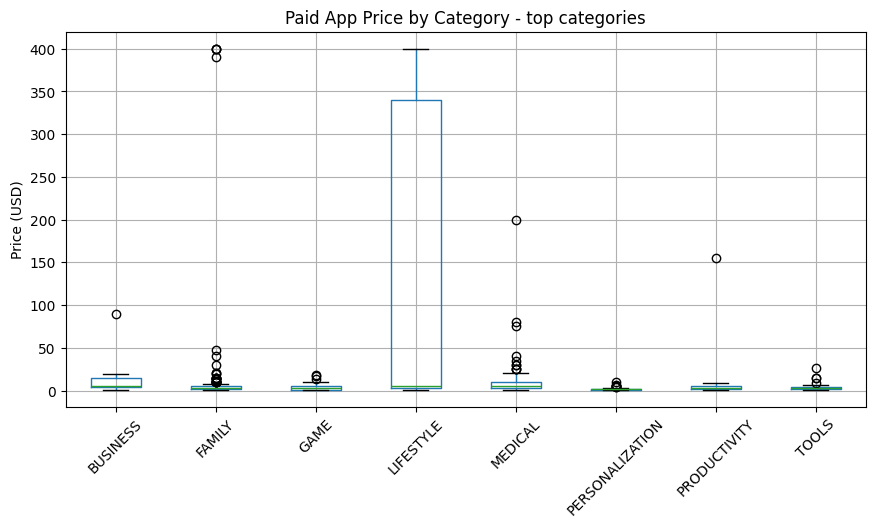

In [17]:
# Price analysis
if 'Price' in apps.columns:
    print("Free vs Paid counts:")
    apps['is_paid'] = apps['Price'].fillna(0) > 0
    display(apps['is_paid'].value_counts())
    # Boxplot of price by top categories (paid apps only)
    paid = apps[apps['is_paid']]
    top_cats = cat_counts.head(8)['category'].tolist()
    subset = paid[paid[category_col].isin(top_cats)]
    if not subset.empty:
        plt.figure(figsize=(10,6))
        # simple price boxplot by category
        subset.boxplot(column='Price', by=category_col, rot=45)
        plt.title("Paid App Price by Category - top categories")
        plt.suptitle('')
        plt.xlabel('')
        plt.ylabel("Price (USD)")
        plt.show()

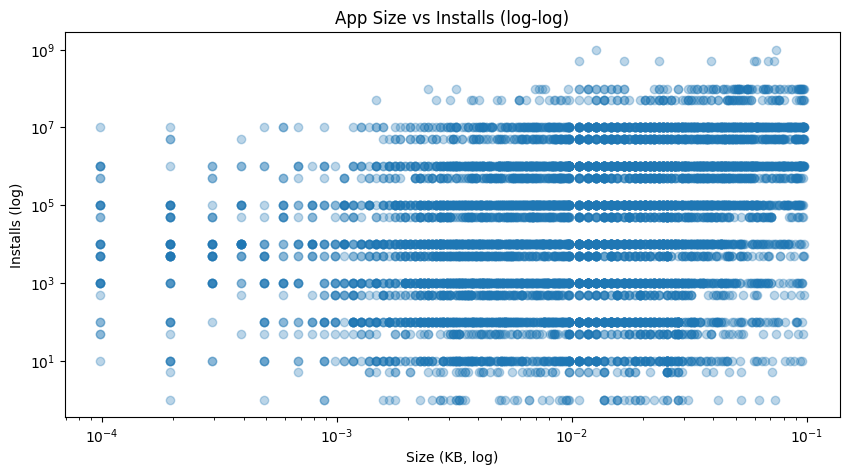

In [18]:
# Size vs Installs (scatter) - Size_kb from cleaning
if 'Size_kb' in apps.columns and 'Installs' in apps.columns:
    df_sz = apps.dropna(subset=['Size_kb', 'Installs'])
    plt.figure()
    plt.scatter(df_sz['Size_kb'], df_sz['Installs'], alpha=0.3)
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel("Size (KB, log)")
    plt.ylabel("Installs (log)")
    plt.title("App Size vs Installs (log-log)")
    plt.show()


# 5. Sentiment Analysis of Reviews

Index(['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
       'Sentiment_Subjectivity'],
      dtype='object')


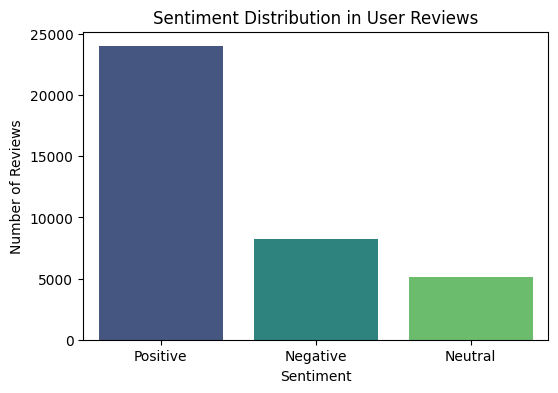

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the reviews file
reviews = pd.read_csv("user_reviews.csv")

# Check columns
print(reviews.columns)

# Drop rows with no Sentiment
reviews = reviews.dropna(subset=['Sentiment'])

# Sentiment distribution
sentiment_counts = reviews['Sentiment'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution in User Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

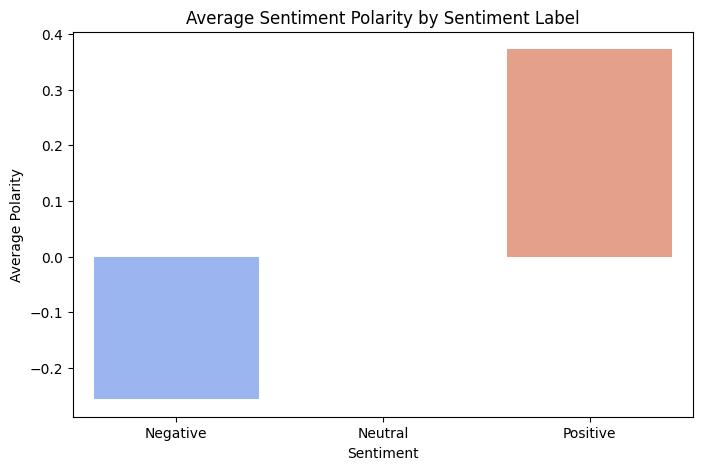

In [26]:
# Average polarity & subjectivity per sentiment
sentiment_stats = reviews.groupby('Sentiment')[['Sentiment_Polarity', 'Sentiment_Subjectivity']].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_stats, x='Sentiment', y='Sentiment_Polarity', palette='coolwarm')
plt.title('Average Sentiment Polarity by Sentiment Label')
plt.ylabel('Average Polarity')
plt.show()

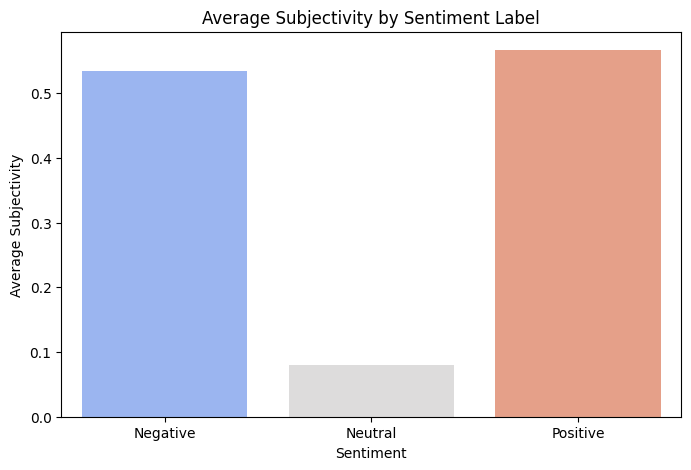

In [27]:
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_stats, x='Sentiment', y='Sentiment_Subjectivity', palette='coolwarm')
plt.title('Average Subjectivity by Sentiment Label')
plt.ylabel('Average Subjectivity')
plt.show()

# 6. Interactive visualization (Plotly) — example: category counts & interactive scatter

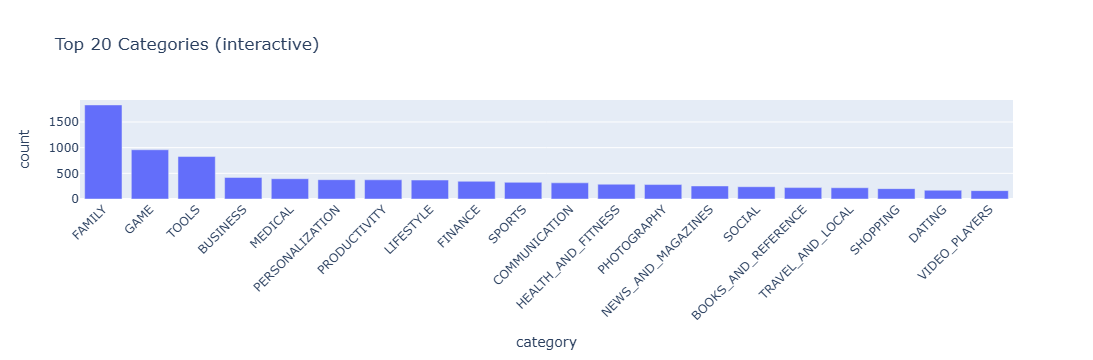

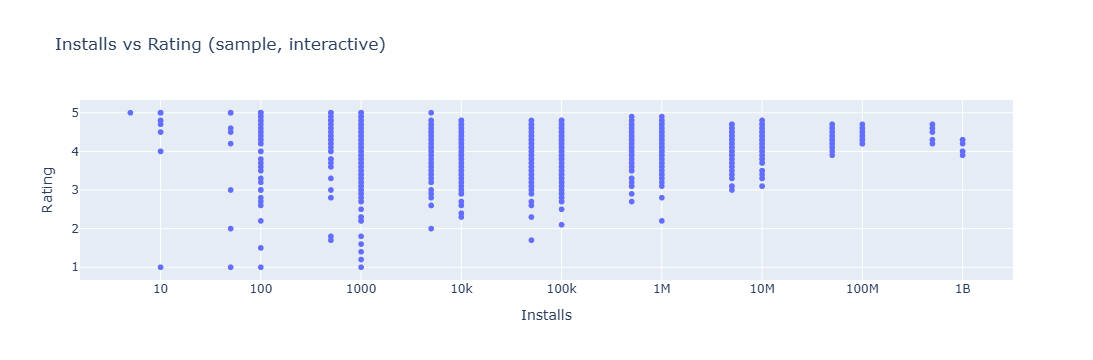

In [36]:
# Cell 6 - Interactive plots with Plotly
# If Plotly is not installed: pip install plotly

try:
    import plotly.express as px
    interactive_available = True
except:
    print("Plotly not installed. Install with: pip install plotly")
    interactive_available = False

if interactive_available:
    # Interactive bar for categories
    fig = px.bar(cat_counts.head(20), x='category', y='count', title='Top 20 Categories (interactive)')
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

    # Interactive scatter: Installs vs Rating (log)
    df_scatter = apps.dropna(subset=['Installs','Rating'])
    fig2 = px.scatter(df_scatter.sample(min(2000, len(df_scatter))), x='Installs', y='Rating',
                      hover_data=['App','Category'] if 'App' in apps.columns else None,
                      log_x=True, title='Installs vs Rating (sample, interactive)')
    fig2.show()
else:
    print("Plotly not available; see earlier static matplotlib plots.")

# 7. Sentiment + Category Insights (join reviews -> apps)

In [30]:
# Cell 7 - Join reviews with apps to get category-level sentiment
# This cell assumes reviews have an 'App' or 'App Name' column matching apps['App'] or similar.

app_name_col_apps = None
for c in apps.columns:
    if c.lower() in ('app', 'app_name', 'title'):
        app_name_col_apps = c
        break

app_name_col_reviews = None
for c in reviews.columns:
    if c.lower() in ('app', 'app_name', 'app_title'):
        app_name_col_reviews = c
        break

print("Apps name col:", app_name_col_apps, "Reviews name col:", app_name_col_reviews)

if app_name_col_apps and app_name_col_reviews:
    merged = reviews.merge(apps[[app_name_col_apps, category_col]], left_on=app_name_col_reviews, right_on=app_name_col_apps, how='left', suffixes=('_rev','_app'))
    print("Merged shape:", merged.shape)
    # if sentiment column exists from earlier (vader_label or proxy_sentiment)
    if 'vader_label' in merged.columns:
        by_cat = merged.groupby(category_col)['vader_label'].value_counts(normalize=True).mul(100).rename('pct').reset_index()
        display(by_cat.head(20))
    elif 'proxy_sentiment' in merged.columns:
        by_cat = merged.groupby(category_col)['proxy_sentiment'].value_counts(normalize=True).mul(100).rename('pct').reset_index()
        display(by_cat.head(20))
    else:
        print("No sentiment labels found in merged reviews. Run sentiment analysis earlier.")
else:
    print("Could not detect matching app name columns for join. Check apps.columns and reviews.columns.")


Apps name col: App Reviews name col: App
Merged shape: (37432, 6)
No sentiment labels found in merged reviews. Run sentiment analysis earlier.


# 8. Skill enhancement — applying visualization best practices (small multiples, annotation, color/shape selection)

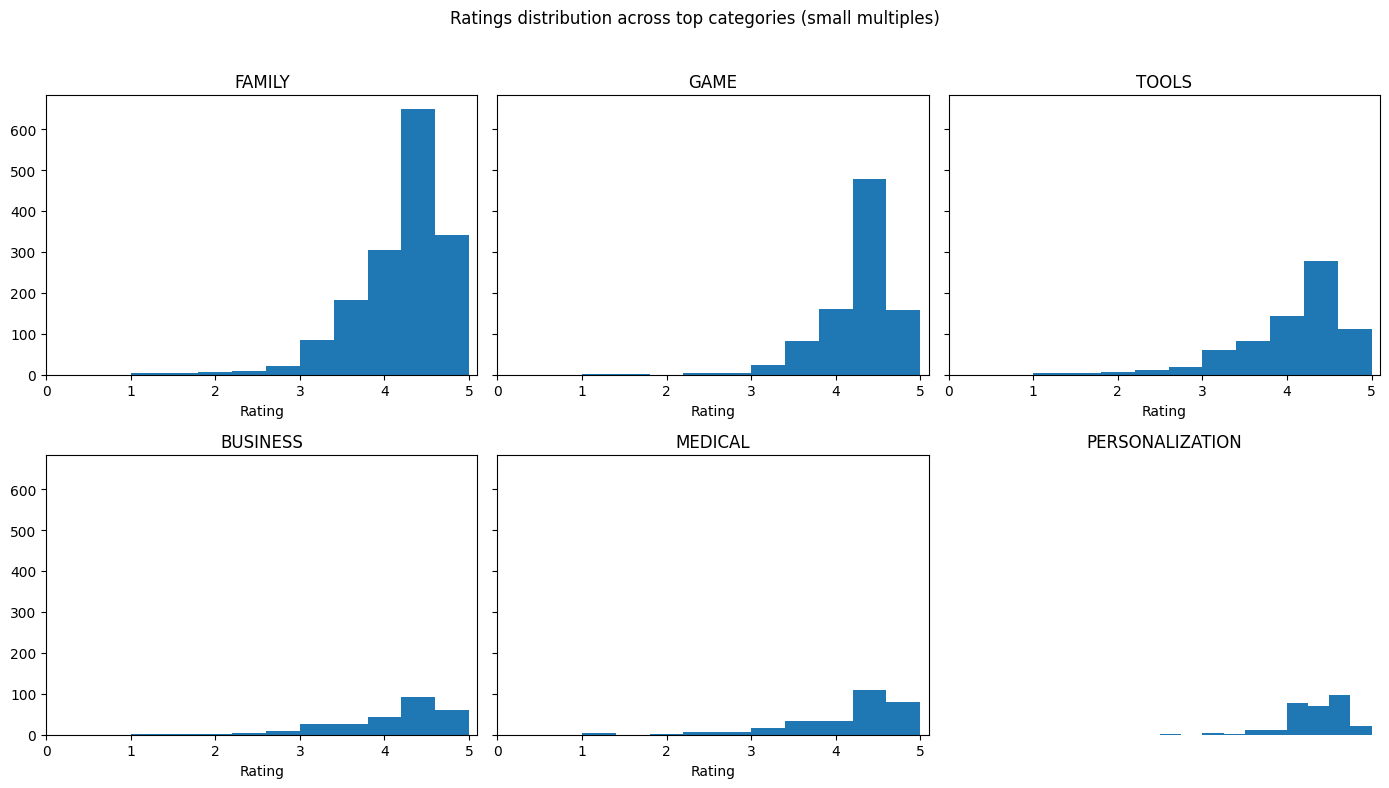

In [37]:
# Cell 8 - Small multiples: Ratings distribution per top categories (matplotlib)
top_cats = cat_counts.head(6)['category'].tolist()
subset = apps[apps[category_col].isin(top_cats)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,8), sharey=True)
axes = axes.flatten()
for ax, cat in zip(axes, top_cats):
    data = subset[subset[category_col]==cat]['Rating'].dropna()
    ax.hist(data, bins=10)
    ax.set_title(cat)
    ax.set_xlim(0,5.1)
    ax.set_xlabel("Rating")
axes[-1].axis('off')  # if fewer categories than axes
plt.suptitle("Ratings distribution across top categories (small multiples)")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

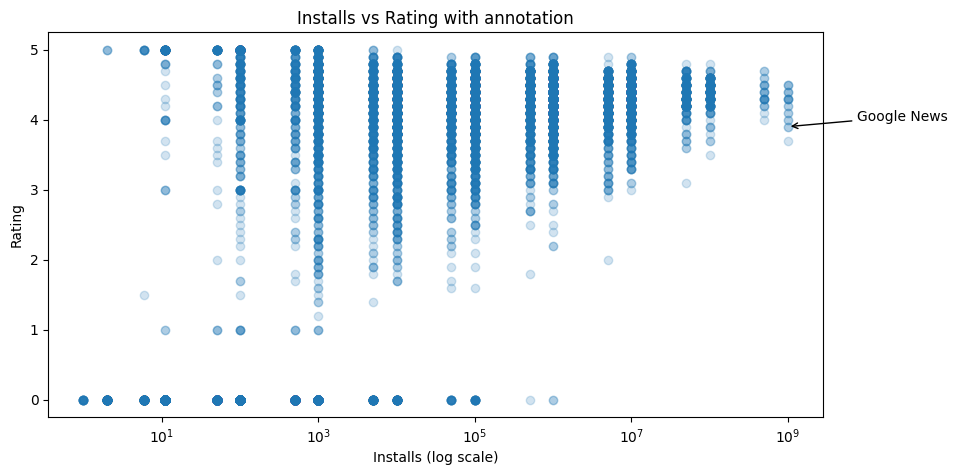

In [38]:
# Annotation example: annotate a high-outlier app
if 'Installs' in apps.columns and 'App' in apps.columns:
    top_installed = apps.sort_values('Installs', ascending=False).head(1).iloc[0]
    plt.figure()
    plt.scatter(apps['Installs'].fillna(0)+1, apps['Rating'].fillna(0), alpha=0.2)
    plt.xscale('log')
    plt.xlabel("Installs (log scale)")
    plt.ylabel("Rating")
    plt.title("Installs vs Rating with annotation")
    plt.annotate(top_installed['App'],
                 xy=(top_installed['Installs'] if pd.notna(top_installed['Installs']) else 0,
                     top_installed['Rating']),
                 xytext=(50, 4.5),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->"))
    plt.show()

# 9. Export cleaned datasets (so you can reuse)

In [39]:
# Cell 9 - Save cleaned datasets to disk
apps.to_csv("apps_cleaned.csv", index=False)
reviews.to_csv("reviews_cleaned.csv", index=False)
print("Exported apps_cleaned.csv and reviews_cleaned.csv to current directory.")

Exported apps_cleaned.csv and reviews_cleaned.csv to current directory.
